# Analysing german news articles

## Imports

In [1]:
# Pandas is an open source data analysis and manipulation tool
import pandas as pd
from pandas import json_normalize 

# os gives access to the operating system
import os
# The datetime module supplies classes for manipulating dates and times.
from datetime import datetime 
import datetime
# This module provides various time-related functions.
import time

# Natural language toolkit
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# library to create visualizations
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import AnchoredText


# open source library for automating downloading of reports from Google Trends
from pytrends.request import TrendReq

# library to get html of website (wikipedia)
import requests
# json to use wikipedia return
import json




## Load data into DataFrames

In [2]:
# Folderpath to CSV's
CSV_folderPath="/Users/jan/Documents/Python_Projects/Bachelorthesis/CSV_Backlog"

# Initialize list<csv> for Spiegel, Sueddeutsche, Bild and combined 
Spiegel_csvs = []
Sueddeutsche_csvs = []
Bild_csvs = []
Combi_csvs = []


# Change directory to CSV_folderPath
os.chdir(CSV_folderPath)

# iterate over all files
for file in os.listdir():
    # that are csvs...
    if file.endswith(".csv"):        
        # read csv to dataframe
        df =pd.read_csv(file, index_col=None, header=0)
        # all df append to combi...
        Combi_csvs.append(df)
        # sort dataframe to its list
        #Spiegel
        if file.startswith("Spiegel"):
            Spiegel_csvs.append(df)
        # Sueddeutsche
        elif file.startswith("Sueddeutsche"):
            Sueddeutsche_csvs.append(df)
        # Bild
        elif file.startswith("Bild"):
            Bild_csvs.append(df)
    
All_articles = pd.concat(Combi_csvs, axis=0, ignore_index=True)
Spiegel_articles = pd.concat(Spiegel_csvs, axis=0, ignore_index=True)
Sueddeutsche_articles = pd.concat(Sueddeutsche_csvs, axis=0, ignore_index=True)
if(len(Bild_csvs)) != 0:
    Bild_articles = pd.concat(Bild_csvs, axis=0, ignore_index=True)
else:
    Bild_articles=[]

    
# Drop duplicates

# All articles
All_articles= All_articles.drop_duplicates(subset="Titel")

# Spiegel articles
Spiegel_articles = Spiegel_articles.drop_duplicates(subset="Titel")

# Sueddeutsch articles
Sueddeutsche_articles = Sueddeutsche_articles.drop_duplicates(subset="Titel")

# Bild articles
#Bild_articles = Bild_articles.drop_duplicates(subset="title")
All_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40751 entries, 0 to 92825
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Titel                  40751 non-null  object 
 1   Date_Info              40751 non-null  object 
 2   URL                    40751 non-null  object 
 3   Overline               30381 non-null  object 
 4   Breadcrumb             21867 non-null  object 
 5   author                 5687 non-null   object 
 6   detailed_informations  8010 non-null   object 
 7   Zugriff_Datum          31259 non-null  float64
 8   News_page              40751 non-null  object 
dtypes: float64(1), object(8)
memory usage: 3.1+ MB


## Data Cleaning

### Cast Date_Info to datetime

In [3]:
# All articles
All_articles["Date_Info"] = All_articles["Date_Info"].str.strip()
All_articles["Date_Info"] = pd.to_datetime(All_articles["Date_Info"], format='%d%m%Y_%H:%M')
# Spiegel articles
Spiegel_articles["Date_Info"] = Spiegel_articles["Date_Info"].str.strip()
Spiegel_articles["Date_Info"] = pd.to_datetime(Spiegel_articles["Date_Info"], format='%d%m%Y_%H:%M')
# Sueddeutsche articles
Sueddeutsche_articles["Date_Info"] = Sueddeutsche_articles["Date_Info"].str.strip()
Sueddeutsche_articles["Date_Info"] = pd.to_datetime(Sueddeutsche_articles["Date_Info"], format='%d%m%Y_%H:%M')
# Bild articles
#Bild_carticles["Date_Info"] = pd.to_datetime(Bild_carticles["Date_Info"], format='%d%m%Y_%H:%M')

## Initial data analysis

### Ammount of articles

In [4]:
# Spiegel articles
ammount_of_Spiegel_articles = len(Spiegel_articles)
print(f"Spiegel articles: {ammount_of_Spiegel_articles}")

# Sueddeutsche articles
ammount_of_Sueddeutsche_articles = len(Sueddeutsche_articles)
print(f"Sueddeutsche articles: {ammount_of_Sueddeutsche_articles}")

# Bild articles
ammount_of_Bild_articles = len(Bild_articles)
print(f"Bild articles: {ammount_of_Bild_articles}")

# All articles
ammount_of_Combined_articles = len(All_articles)
print(f"Overall: {ammount_of_Combined_articles}")

Spiegel articles: 9492
Sueddeutsche articles: 31261
Bild articles: 0
Overall: 40751


# Helper

### Exploding titles

In [5]:
def explode_titles(title_column):
    title_column =title_column.to_frame()
    tokenized_titles=[]
    title_column["tokenized_title"] = ""
    for index, row in title_column.iterrows():
        # tokenize
        tokenized_title = word_tokenize(row.Titel)
        
        # remove stopwords & numbers/punction
        tokenized_title = [word for word in tokenized_title if word not in stopwords.words("german")]
        
        # add to row
        row.tokenized_title = tokenized_title
        
    return title_column

In [6]:
def make_chunks(data, chunk_size): 
    while data:
        chunk, data = data[:chunk_size], data[chunk_size:]
        yield chunk

### Google

In [29]:
def get_google_interest_over_time(keyword_list):
    # connect to google
    pytrends = TrendReq(hl='de', tz='60') 

    # keywords
    keywords = keyword_list

    # build payload
    startDate = "2021-11-07"
    dateTime=datetime.datetime.now()
    currentDate = dateTime.strftime("%Y-%m-%d")
    timeframe = startDate +" "+ str(currentDate)
    dataframes = []
    for keyword in keywords:
        keyword_list = []
        keyword_list.append(keyword)
        pytrends.build_payload(keyword_list, cat=0, timeframe= str(timeframe) ) 
        
        # get data with interest over time
        data = pytrends.interest_over_time() 
        dataframes.append(data)
        time.sleep(1.5)
    
    # concat all google trends results
    dfs = pd.concat(dataframes, axis=1)
    # remove deprecated column
    dfs=dfs.loc[:,~dfs.columns.str.startswith('isPartial')]

    # get df to right format
    google_df = dfs.unstack().reset_index() 
    google_df = google_df.rename(columns={"level_0" : "KeyWord", 0 : "Occurence_in_Google"})
    
    #fill all NaN with 0
    google_df["Occurence_in_Google"] = google_df["Occurence_in_Google"].fillna(0)
    google_df["Occurence_in_Google"] = google_df["Occurence_in_Google"].astype(int)
    
    google_df["Occurence_in_Google_normalized"] = google_df["Occurence_in_Google"].div(100)
    return google_df

# Wikipedia

In [65]:
def get_wikipedia_interest_over_time(keyword_list):
    dateTime=datetime.datetime.now()
    currentDate = dateTime.strftime("%Y%m%d")
    return_list=[]
    # chunk keywords due to wikimedia policy
    for chunk in make_chunks(keyword_list, 200):        
        for keyword in chunk:
            headers = {'user-agent': 'Influence_of_daily_political_news_on_the_use_of_wikipedia/1.0 (jan.schuckatt-online.de)'}
            url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/de.wikipedia.org/all-access/all-agents/{keyword}/daily/20211107/{currentDate}"
            r = requests.get(url, headers=headers)
            return_list.append(r.text)
        time.sleep(5)
    # deserialize json   
    json_dict=[]
    print(return_list)
    return
    for wiki_dict in return_list:
        data = json.loads(wiki_dict)
        json_dict.append(data)
        
    #json to dataframe
    lst_of_df=[]
    for counter in range(len(json_dict)):
        try:
            lst_of_df.append(pd.DataFrame.from_records(json_dict[counter]["items"]))
        except:
            print(json_dict[counter])
    return_DF = pd.concat(good_dfs)
    return_DF = return_DF.rename(columns={'article': 'keyWord', 'timestamp': 'date',"views" : "Occurence in Wikipedia"})
    return_DF = return_DF.drop(['project', 'granularity',"access","agent"], axis=1, inplace=True)
    return return_DF
             


In [56]:
raw_wikiData_jsons = get_wikipedia_interest_over_time(keyword_list)


NameError: name 'keyword_list' is not defined

### Titles 

In [10]:
def get_occurence_of_all_titles(data_frame, columnName):
    # Group titles by columnName
    all_titles = data_frame.groupby(columnName).size()
    
    #sort titles
    all_titles = all_titles.sort_values(ascending = False)
    
    return all_titles

def get_occurence_of_all_capital_titles(data_frame, columnName):
    all_titles=data_frame.groupby(columnName).size()

    capital_titles=[]
    counter=0
    for title in all_titles.items():
        title_s=str(title)
        title_s=title_s.strip()
        if title_s.istitle():
            capital_titles.append(title)        
    Titles = pd.DataFrame.from_records(
    capital_titles, columns=['Title','Occurence'])
    return Titles.sort_values(by=['Occurence'],ascending=False)

def get_titles_with_minimum_occurence_N(data_frame, N):
    all_Titles = get_occurence_of_all_capital_titles(data_frame, "tokenized_titles")
    above_N = []
    for index,row in all_Titles.iterrows():
        if int(row.Occurence) >= N:
            above_N.append(row)
            
    above_N = pd.DataFrame(above_N, columns=['Title', 'Occurence'])

    return data_frame[data_frame["tokenized_titles"].isin(above_N.Title)]

def get_titles_with_minimum_occurence_N(data_frame, N):
    all_Titles = get_occurence_of_all_capital_titles(data_frame, "tokenized_titles")
    above_N = []
    for index,row in all_Titles.iterrows():
        if int(row.Occurence) >= N:
            above_N.append(row)
            
    above_N = pd.DataFrame(above_N, columns=['Title', 'Occurence'])

    return data_frame[data_frame["tokenized_titles"].isin(above_N.Title)]        

# Build big Dataframe

In [11]:
All_articles["tokenized_titles"] = explode_titles(All_articles["Titel"]).tokenized_title
All_articles = All_articles.explode("tokenized_titles")
uninteresting_titles= ["Der", "Die", "Das","Was","Warum","Er","Sie", "Es", "Ich", "Du", "Mit","Wie","Ein","So","Wir",
                       ":","»","«", "," ,"\'\'","``", "_","-" ".","?","–", "-",".","!"]

All_articles=All_articles[~All_articles.tokenized_titles.isin(uninteresting_titles)]


## Analysis

### Ammount of articles with occurence above n

In [12]:
occurence = [10,25,50,75,100,125,150,200]
for n in occurence:
    x = get_titles_with_minimum_occurence_N(All_articles, n)
    y = get_occurence_of_all_capital_titles(x,"tokenized_titles")
    print("n:"+str(n) +" = "+str(len(y)))

n:10 = 2442
n:25 = 853
n:50 = 344
n:75 = 194
n:100 = 118
n:125 = 81
n:150 = 57
n:200 = 35


# Build Occurence DF

In [32]:
def build_Occurence_df(dataframe, n_occurences):
    article_over_occurence = get_titles_with_minimum_occurence_N(dataframe[["Date_Info", "tokenized_titles"]], n_occurences)

    # prep keyword list "Titles"
    keyword_list = list(article_over_occurence["tokenized_titles"].drop_duplicates())
    # get google data
    google_data = get_google_interest_over_time(keyword_list)
    # get wikipedia data
    wikipedia_data = get_wikipedia_interest_over_time(keyword_list)

    #rename columns
    article_over_occurence = article_over_occurence.rename(columns={"Date_Info" : "date", "tokenized_titles" : "Occurence_in_news"})
    #convert to datetime
    article_over_occurence['date'] = pd.to_datetime(article_over_occurence.date) 
    #convert datetime format to googles datetime format
    article_over_occurence['date'] = article_over_occurence['date'].dt.strftime('%Y-%m-%d')
    #reshape our data frame to look like google data frame
    occurence_df=article_over_occurence.pivot_table(index='date', columns='Occurence_in_news', aggfunc='size') \
                .rename_axis(None, axis=1)
    #fill all NaN with 0
    occurence_df = occurence_df.fillna(0)
    occurence_df = occurence_df.astype(int)

    # bring news df to right format
    news_df = occurence_df.unstack().reset_index()
    news_df = news_df.rename(columns={"level_0" : "KeyWord", 0 : "Occurence_in_News"})
    news_df["date"]=pd.to_datetime(news_df["date"], format='%Y-%m-%d')
        
    # merge google and news
    full_df = pd.merge(news_df, google_data, on=['KeyWord',"date"], how='outer')
    #fill all NaN with 0
    full_df["Occurence_in_Google"] = full_df["Occurence_in_Google"].fillna(0)
    full_df["Occurence_in_Google"] = full_df["Occurence_in_Google"].astype(int)
    return full_df
    
    

In [ ]:
    for keyword in keyword_list:
        keyworded_dataFrame = full_df.loc[full_df["KeyWord"] == keyword]

        df_chunk = keyworded_dataFrame
        df_chunk["Occurence_in_News_Normalized"]=(keyworded_dataFrame["Occurence_in_News"]-keyworded_dataFrame["Occurence_in_News"].min())/(keyworded_dataFrame["Occurence_in_News"].max()-keyworded_dataFrame["Occurence_in_News"].min())
        print(keyword)
        data_frame_list.append(df_chunk)

In [33]:
df=build_Occurence_df(All_articles,50)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [35]:
df_with_index = df.set_index("KeyWord")

In [63]:
wikipedia_data = get_wikipedia_interest_over_time(["Corona", "Mann", "Polizei"])

['{"items":[{"project":"de.wikipedia","article":"Corona","granularity":"daily","timestamp":"2021110700","access":"all-access","agent":"all-agents","views":418},{"project":"de.wikipedia","article":"Corona","granularity":"daily","timestamp":"2021110800","access":"all-access","agent":"all-agents","views":431},{"project":"de.wikipedia","article":"Corona","granularity":"daily","timestamp":"2021110900","access":"all-access","agent":"all-agents","views":376},{"project":"de.wikipedia","article":"Corona","granularity":"daily","timestamp":"2021111000","access":"all-access","agent":"all-agents","views":495},{"project":"de.wikipedia","article":"Corona","granularity":"daily","timestamp":"2021111100","access":"all-access","agent":"all-agents","views":533},{"project":"de.wikipedia","article":"Corona","granularity":"daily","timestamp":"2021111200","access":"all-access","agent":"all-agents","views":446},{"project":"de.wikipedia","article":"Corona","granularity":"daily","timestamp":"2021111300","access"

In [76]:
def get_wikipedia_interst_over_time1(keyword_list):
    dateTime=datetime.datetime.now()
    currentDate = dateTime.strftime("%Y%m%d")
    return_list=[]
    # chunk keywords due to wikimedia policy
    for chunk in make_chunks(keyword_list, 200):        
        for keyword in chunk:
            headers = {'user-agent': 'Influence_of_daily_political_news_on_the_use_of_wikipedia/1.0 (jan.schuckatt-online.de)'}
            url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/de.wikipedia.org/all-access/all-agents/{keyword}/daily/20211107/{currentDate}"
            r = requests.get(url, headers=headers)
            return_list.append(r.text)
        time.sleep(5)
    # deserialize json   
    json_dict=[]
    for wiki_dict in raw_wikiData_jsons:
        data = json.loads(wiki_dict)
        json_dict.append(data)
        
    #json to dataframe
    lst_of_df=[]
    for counter in range(len(json_dict)):
        try:
            lst_of_df.append(pd.DataFrame.from_records(json_dict[counter]["items"]))
        except:
            print(json_dict[counter])
    return pd.concat(good_dfs)



In [77]:
testDF = get_wikipedia_interst_over_time1(["Corona", "Polizei"])

NameError: name 'raw_wikiData_jsons' is not defined

In [ ]:
# NEWSPAGE
# get all titles that occure above N
article_over_occurence = get_titles_with_minimum_occurence_N(All_articles[["Date_Info", "tokenized_titles"]], 50)

# prep keyword list "Titles"
keyword_list = list(article_over_occurence["tokenized_titles"].drop_duplicates())

#rename columns
article_over_occurence = article_over_occurence.rename(columns={"Date_Info" : "date", "tokenized_titles" : "Occurence_in_news"})
#convert to datetime
article_over_occurence['date'] = pd.to_datetime(article_over_occurence.date) 
#convert datetime format to googles datetime format
article_over_occurence['date'] = article_over_occurence['date'].dt.strftime('%Y-%m-%d')
#reshape our data frame to look like google data frame
occurence_df=article_over_occurence.pivot_table(index='date', columns='Occurence_in_news', aggfunc='size') \
            .rename_axis(None, axis=1)
#fill all NaN with 0
occurence_df = occurence_df.fillna(0)
occurence_df = occurence_df.astype(int)

# GOOGLE 
# google trends laden
data = google_interest_over_time(keyword_list)
# concat all google trends results
dfs = pd.concat(data, axis=1)
# remove deprecated column
dfs=dfs.loc[:,~dfs.columns.str.startswith('isPartial')]


# get current datetime for later filenames
date_time = datetime.datetime.today().strftime("%d_%m_%Y")
# list where all plots land
all_plots=[]
# list where 
#iterate over keyword list
for keyword in keyword_list:
    # get series for news
    news_data = occurence_df[keyword]
    # get series for google
    google_data = dfs[keyword]
    
    # rename the Series
    news_data= news_data.rename("News_Data")
    google_data = google_data.rename("Google_Data")
    
    # cast to dataframe 
    news_data = news_data.to_frame()
    google_data = google_data.to_frame()
    # reset index
    news_data = news_data.reset_index()
    
    news_data['date'] = pd.to_datetime(news_data.date) 
    merged_data = pd.merge(news_data,google_data, how="outer", on="date")
    merged_data.to_csv("/Users/jan/Documents/Python_Projects/Bachelorthesis/Analysis/News_vs_Google/news_vs_google"+date_time+"_"+keyword +".csv",index=False)
    all_plots.append(createFigure(merged_data,keyword))


# save all figures in one pdf
with PdfPages("/Users/jan/Documents/Python_Projects/Bachelorthesis/Analysis/News_vs_Google/news_vs_google"+date_time +".pdf") as pdf:
    for plot in all_plots:
        pdf.savefig(plot)


In [ ]:
def createFigure(data_frame, fileName):
    plot = data_frame.plot.line(x="date",y=[1,2],figsize=(20,10), title="Occurence of "+fileName)
    Correlation = data_frame["News_Data"].corr(data_frame["Google_Data"])
    plot.annotate("Correlation: " + str(Correlation) , xy=(0.05, 0.95), xycoords='axes fraction')    
    return plot.get_figure()



## Plots

### Plot occurence of top 50 titles

In [ ]:
# get all titles
all_titles = get_occurence_of_all_titles(All_articles,"tokenized_titles")

# get top 50
top50_titles = all_titles[:50]

plt.figure(figsize=(20,3))
top50_titles.plot(kind="bar")

### Plot occurence of top 50 titles starting with capital letter

<AxesSubplot:xlabel='Title'>

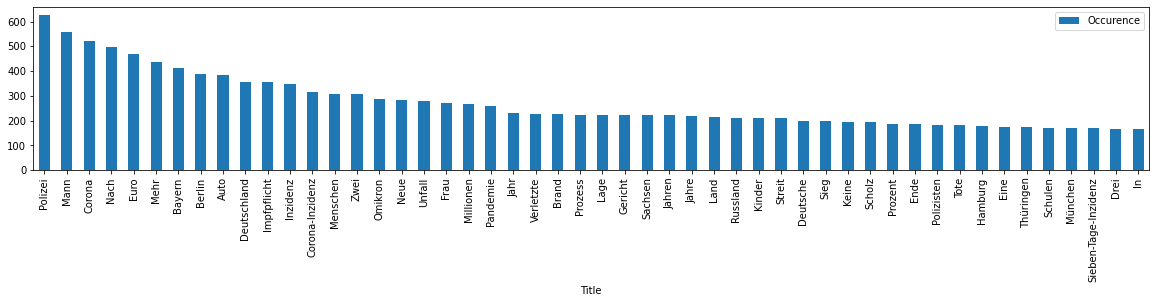

In [58]:
# get all titles
all_titles = get_occurence_of_all_capital_titles(All_articles,"tokenized_titles")

#get top 50
top50_titles = all_titles[:50]

#plot
top50_titles.plot.bar(x="Title",y="Occurence",figsize=(20, 3))


In [54]:
def saveCSV(dataframe):
    dataframe.to_csv("/Users/jan/Documents/Python_Projects/Bachelorthesis/Analysis/"+"dataframe" +".csv",index=False)


In [55]:
saveCSV(df)